In [1]:
import csv
import utm
import math
import requests
import pyperclip
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure

In [2]:
# PLEASE READ AT LEAST THE BEGINNING OF THE DATA APPROACH DOCUMENT BEFORE RUNNING THIS CODE
# common error #1:
# not changing all the ", " strings in the csv file to "," strings

# common error #2
# Please move all the FMT, UNIT, MULT, and FMTU commands in that order to the top of the file
# if things are breaking.

file_header_format = []
MULTs = {}
UnitKeys = {}
FMTs = {}
TypeIDs = {}
COLs = {}
counts = {}
PARAMs = {}
DATA = {}
DATA2 = {}

In [3]:

def get_col_index(fmt, name, meta_data=COLs):
    return meta_data[fmt]['col_names'].index(name.lower()) + 1


def all_to_lower(array):
    to_return = []
    for string in array:
        to_return.append(string.lower())
    return to_return


# Converting each datapoint from a string to its type specified by its type character
def convert_data_point(data, type_char):

    try:
        if type_char == 'h' or type_char == 'H' or type_char == 'i' or type_char == 'I' or type_char == 'Q':
            return int(data)
        elif type_char == 'f':
            return float(data)
        try:
            return int(data)
        except ValueError:
            return float(data)

    except ValueError:
        return data

In [4]:
# Documentation: https://ardupilot.org/copter/docs/logmessages.html

import time

time1 = time.time()

DATA2 = {}

# Change these to your file_name
file_name = '2022-05-05 10-53-43.csv'
cur_folder = 'data_' + file_name.split(" ")[0]

# if your file is in a folder, specify here 
path_to_file = 'original_data/' + file_name


row_count = 0
with open(path_to_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',') # May need to replace all ", " with ","
    file_header_format = csv_reader.__next__()
    COLs[file_header_format[0]] = {'col_names':[], 'units':{}, 'mult_factor':{}, 'data_type':[]}
    COLs[file_header_format[0]]['col_names'] = all_to_lower(file_header_format[5:])
    TypeIDs[int(file_header_format[1])] = file_header_format[0]
    COLs[file_header_format[0]]['data_type'] = list(file_header_format[4])

    for row in csv_reader:

        # Count the number of occurrences of each format type for reference
        try:
            val = counts[row[0]]
            counts[row[0]] = val + 1
        except KeyError:
            counts[row[0]] = 1

        # Format Element
        # This related a format type (a 2-4 character string) to a format id
        # and the names of the data points that will appear whenever that format icon is logged
        if row[0] == 'FMT':
            data_point = row[get_col_index(row[0], 'Name')]
            COLs[data_point] = {'col_names':[], 'units':{}, 'mult_factor':{}, 'data_type':[]}
            COLs[data_point]['col_names'] = all_to_lower(row[5:])
            TypeIDs[int(row[1])] = data_point

            type_string = row[get_col_index(row[0], 'Format')]
            COLs[data_point]['data_type'] = list(type_string)
            continue

        # Relating a multiplication term to a specific characters
        # Each format type id is mapped a specific character to specific a
        # number it should be multiplied by To get that datapoint's actual value
        if row[0] == 'MULT':
            integer = int(row[2])
            MULTs[chr(integer)] = float(row[3] if row[3] != '' else ' ')
            continue

        # Relating a unit type to a specific character
        # Each format type id then is mapped to a specific character to specify its type
        if row[0] == 'UNIT':
            integer = int(row[2])
            UnitKeys[chr(integer)] = row[3]
            continue

        # Format Block Element
        if row[0] == 'FMTU':
            fmt_type_id = int(row[get_col_index(row[0], 'FmtType')])
            fmt_type = TypeIDs[fmt_type_id]
            unit_string = row[get_col_index(row[0], 'UnitIds')]
            mult_string = row[get_col_index(row[0], 'MultIds')]

            unit_list = []
            mult_list = []

            for c in unit_string:
                unit_list.append(UnitKeys[c])

            for c in mult_string:
                mult_list.append(float(MULTs[c]))

            unit_dict = {}
            mult_dict = {}

            for col_name, unit, mult, in zip(COLs[fmt_type]['col_names'], unit_list, mult_list):
                unit_dict[col_name] = unit
                mult_dict[col_name] = mult

            COLs[fmt_type]['units'] = unit_dict
            COLs[fmt_type]['mult_factor'] = mult_dict
            continue

        # Defines specific octo-copter params
        if row[0] == 'PARM':
            PARAMs[row[2]] = {}
            PARAMs[row[2]]['time'] = int(row[1])

            try:
                PARAMs[row[2]]['value'] = int(row[3])
            except ValueError:
                PARAMs[row[2]]['value'] = float(row[3])

            continue

        # All other format types can be parsed using the same code

        fmt_type = row[0]
        key_list = DATA2.keys()

        if fmt_type not in key_list:
            new_df = {}
            for col_name in COLs[fmt_type]['col_names']:
                new_df[col_name] = []
            DATA2[fmt_type] = pd.DataFrame(new_df) # , dtype='int'

        new_row = {}

        i = 1
        for col_name, data_type in zip(COLs[fmt_type]['col_names'], COLs[fmt_type]['data_type']):
            if isinstance(row[i], list): # Some rows come in as 2d lists for some reason
                new_row[col_name] = [convert_data_point(row[i][0], data_type)]
            else:
                new_row[col_name] = [convert_data_point(row[i], data_type)]
            i = i + 1

        new_row = pd.DataFrame(new_row)


        DATA2[fmt_type] = pd.concat([DATA2[fmt_type], new_row], ignore_index = True)

        row_count = row_count + 1

        if row_count % 1000 == 0:
            print(row_count)

DATA = DATA2

load_time = time.time() - time1

print("Load time in sec: " + str(load_time))

# 163.561

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [5]:
DATA2 = {}

In [6]:
COLs

{'FMT': {'col_names': ['type', 'length', 'name', 'format', 'columns'],
  'units': {'type': '',
   'length': 'B',
   'name': '',
   'format': '',
   'columns': ''},
  'mult_factor': {'type': 0.0,
   'length': 0.0,
   'name': 0.0,
   'format': 0.0,
   'columns': 0.0},
  'data_type': ['B', 'B', 'n', 'N', 'Z']},
 'UNIT': {'col_names': ['timeus', 'id', 'label'],
  'units': {'timeus': 's', 'id': '', 'label': ''},
  'mult_factor': {'timeus': 9.99999997475243e-07, 'id': 0.0, 'label': 0.0},
  'data_type': ['Q', 'b', 'Z']},
 'FMTU': {'col_names': ['timeus', 'fmttype', 'unitids', 'multids'],
  'units': {'timeus': 's', 'fmttype': '', 'unitids': '', 'multids': ''},
  'mult_factor': {'timeus': 9.99999997475243e-07,
   'fmttype': 0.0,
   'unitids': 0.0,
   'multids': 0.0},
  'data_type': ['Q', 'B', 'N', 'N']},
 'MULT': {'col_names': ['timeus', 'id', 'mult'],
  'units': {'timeus': 's', 'id': '', 'mult': ''},
  'mult_factor': {'timeus': 9.99999997475243e-07, 'id': 0.0, 'mult': 0.0},
  'data_type': ['Q'

In [7]:
# Web Scrapping:
URL = "https://ardupilot.org/copter/docs/logmessages.html"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

format_descriptions = {}

for data_points in counts.keys():

    results = soup.find("div", id=data_points.lower())
    if results is None:
        if data_points[len(data_points)-1].isnumeric():
            results = soup.find("div", id=data_points[:len(data_points)-1].lower())

        if results is None:
            format_descriptions[data_points] = {'general': 'UNKNOWN'}
            continue

    p_general = results.find("p").text

    format_descriptions[data_points] = {'general': p_general}

    results = results.find("table")
    table_elements = results.find_all("td")
    previous = None
    for elem in table_elements:
        if previous is not None:
            format_descriptions[data_points][previous] = elem.text
            previous = None
        else:
            previous = elem.text.lower()


# Battery (voltage and current)
# RPM, Thrust, and Thrust (%) -- separate files


In [8]:
format_descriptions

{'FMT': {'general': 'Message defining the format of messages in this file',
  'type': 'unique-to-this-log identifier for message being defined',
  'length': 'the number of bytes taken up by this message (including all headers)',
  'name': 'name of the message being defined',
  'format': 'character string defining the C-storage-type of the fields in this message',
  'columns': 'the labels of the message being defined'},
 'UNIT': {'general': 'Message mapping from single character to SI unit',
  'timeus': 'Time since system startup',
  'id': 'character referenced by FMTU',
  'label': 'Unit - SI where available'},
 'MULT': {'general': 'Message mapping from single character to numeric multiplier',
  'timeus': 'Time since system startup',
  'id': 'character referenced by FMTU',
  'mult': 'numeric multiplier'},
 'EV': {'general': 'Specifically coded event messages',
  'timeus': 'Time since system startup',
  'id': 'Event identifier\nValues:\n\n\n\n\n\n\n\nARMED\n10\n\n\nDISARMED\n11\n\n\nAUTO

In [9]:
key_list = counts.keys()
key_list = sorted(key_list)
with open(cur_folder + "/data_description.txt", 'w', encoding='utf8') as output_file:
    for key in format_descriptions:

        output_file.write("----------NEW FORMAT----------\n")
        output_file.write(key + ": " + format_descriptions[key]['general'] + "\n")
        for col_name in COLs[key]['col_names']:
            try:
                output_file.write(col_name + ": " + format_descriptions[key][col_name] + "\n")
            except KeyError:
                output_file.write(col_name + " UNKNOWN" + "\n")
        output_file.write("\n")


In [10]:
def print_format_info(fmt, data=format_descriptions):

    try:
        print(fmt + ":", data[fmt]['general'])
    except KeyError:
        print("Key: \'" +fmt + "\' is not present in the log file")
        return
    for col in COLs[fmt]['col_names']:
        try:
            print(col + ":", data[fmt][col])
        except KeyError:
            print(col, "UNKNOWN")

def print_all_keys(data=format_descriptions):
    for fmt_key in data:
        print(fmt_key + ":", format_descriptions[fmt_key]['general'])

def search_for_keyword(keyword, data=format_descriptions):
    for fmt_key in data.keys():
        printed = False
        print_general = False
        print_string = ""

        for col in data[fmt_key].keys():
            if keyword.lower() in data[fmt_key][col.lower()].lower():
                if col == 'general':
                    print_general = True
                print_string = print_string + fmt_key + ", "  + col + ": " + data[fmt_key][col.lower()] + "\n"
                printed = True

        if printed and print_general:
            print(print_string)
        elif printed:
            print(fmt_key + ", general: " + data[fmt_key]['general'])
            print(print_string)

In [11]:
search_for_keyword("speed")
#format_descriptions
#print_format_info("CMD")

#DATA['GPS']

EV, general: Specifically coded event messages
EV, id: Event identifier
Values:







ARMED
10


DISARMED
11


AUTO_ARMED
15


LAND_COMPLETE_MAYBE
17


LAND_COMPLETE
18


NOT_LANDED
28


LOST_GPS
19


FLIP_START
21


FLIP_END
22


SET_HOME
25


SET_SIMPLE_ON
26


SET_SIMPLE_OFF
27


SET_SUPERSIMPLE_ON
29


AUTOTUNE_INITIALISED
30


AUTOTUNE_OFF
31


AUTOTUNE_RESTART
32


AUTOTUNE_SUCCESS
33


AUTOTUNE_FAILED
34


AUTOTUNE_REACHED_LIMIT
35


AUTOTUNE_PILOT_TESTING
36


AUTOTUNE_SAVEDGAINS
37


SAVE_TRIM
38


SAVEWP_ADD_WP
39


FENCE_ENABLE
41


FENCE_DISABLE
42


ACRO_TRAINER_OFF
43


ACRO_TRAINER_LEVELING
44


ACRO_TRAINER_LIMITED
45


GRIPPER_GRAB
46


GRIPPER_RELEASE
47


PARACHUTE_DISABLED
49


PARACHUTE_ENABLED
50


PARACHUTE_RELEASED
51


LANDING_GEAR_DEPLOYED
52


LANDING_GEAR_RETRACTED
53


MOTORS_EMERGENCY_STOPPED
54


MOTORS_EMERGENCY_STOP_CLEARED
55


MOTORS_INTERLOCK_DISABLED
56


MOTORS_INTERLOCK_ENABLED
57


ROTOR_RUNUP_COMPLETE
58
Heli only

ROTOR_SPEED_BELOW_CRITICAL
59

In [12]:
# Plot Position:

position_frame  = DATA['POS']
gps_frame = DATA['GPS']

gps_time = gps_frame['timeus'] * (1/1000000)
gps_lat = gps_frame['lat']
gps_lng = gps_frame['lng']
gps_gr_spd = gps_frame['spd']
gps_alt = gps_frame['alt']
gps_vz = gps_frame['vz']

pos_time = position_frame['timeus'] * (1/1000000)
pos_lat = position_frame['lat']
pos_lng = position_frame['lng']

pos_lat_lng = position_frame[['lat', 'lng']]
gps_lat_lng = gps_frame[['lat', 'lng']]

psc_frame = DATA['PSC']
psc_time = psc_frame['timeus'] * (1/1000000)
psc_velocities = psc_frame[['vx', 'vy']]


In [13]:
def binary_search(target, array):
    """
    Returns the index in the sorted array of that is closest to target.

    :param target: The target value.
    :param array: The sorted array to search.
    :return: The index in the array that is closest to target.
    """
    return rec_bin_search(target, 0, len(array), array)

def rec_bin_search(target, start, end, array):
    center = int(abs(end+start)/2)
    if abs(end-start) <= 1:
        if abs(target-end) < abs(target-start):
            return end
        else:
            return start
    elif target == array[center]:
        return center
    elif target > array[center]:
        return rec_bin_search(target, center+1, end, array)
    elif target < array[center]:
        return rec_bin_search(target, start, center-1, array)


In [14]:
DATA['CMD']

,timeus,ctot,cnum,cid,prm1,prm2,prm3,prm4,lat,lng,alt,frame
0,1.339793e+09,21.0,0.0,16.0,0.0,0.0,0.0,0.0,37.102305,-76.386968,2.82,0.0
1,1.339793e+09,21.0,1.0,22.0,0.0,0.0,0.0,0.0,0.000000,0.000000,10.00,3.0
2,1.339793e+09,21.0,2.0,115.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0
3,1.339793e+09,21.0,3.0,16.0,0.0,0.0,0.0,0.0,37.102511,-76.386931,30.00,3.0
4,1.339793e+09,21.0,4.0,178.0,0.0,7.0,0.0,0.0,0.000000,0.000000,0.00,0.0
5,1.339793e+09,21.0,5.0,16.0,0.0,0.0,0.0,0.0,37.102533,-76.385086,30.00,3.0
6,1.339793e+09,21.0,6.0,178.0,0.0,7.0,0.0,0.0,0.000000,0.000000,0.00,0.0
7,1.339793e+09,21.0,7.0,16.0,0.0,0.0,0.0,0.0,37.103538,-76.385086,30.00,3.0
8,1.339793e+09,21.0,8.0,16.0,0.0,0.0,0.0,0.0,37.104022,-76.385525,30.00,3.0
9,1.339793e+09,21.0,9.0,178.0,0.0,7.0,0.0,0.0,0.000000,0.000000,0.00,0.0


In [15]:
ctot = int(DATA['CMD']['ctot'][0])
waypoints_lat_lng = DATA['CMD'].iloc[:ctot][DATA['CMD'].iloc[:ctot].cid == 16.0][['lat', 'lng', 'alt']]

waypoints_x = []
waypoints_y = []
waypoints_height = np.asarray(waypoints_lat_lng['alt'])

for index, row in waypoints_lat_lng.iterrows():
    x, y, _, _ = utm.from_latlon(float(row["lat"]), float(row["lng"]))
    waypoints_x.append(x)
    waypoints_y.append(y)

pos_x_cords = []
pos_y_cords = []

for index, row in pos_lat_lng.iterrows():
    x, y, _, _ = utm.from_latlon(float(row["lat"]), float(row["lng"]))
    pos_x_cords.append(x)
    pos_y_cords.append(y)

gps_x_cords = []
gps_y_cords = []

for index, row in gps_lat_lng.iterrows():
    x, y, _, _ = utm.from_latlon(float(row["lat"]), float(row["lng"]))
    gps_x_cords.append(x)
    gps_y_cords.append(y)

pos_x_cords = np.asarray(pos_x_cords)
pos_y_cords = np.asarray(pos_y_cords)
gps_x_cords = np.asarray(gps_x_cords)
gps_y_cords = np.asarray(gps_y_cords)
waypoints_x = np.asarray(waypoints_x)
waypoints_y = np.asarray(waypoints_y)

add_pos_x = -1 * pos_x_cords[0]
add_pos_y = -1 * pos_y_cords[0]

pos_x_cords = pos_x_cords + add_pos_x
pos_y_cords = pos_y_cords + add_pos_y

add_gps_x = -1 * gps_x_cords[0]
add_gps_y = -1 * gps_y_cords[0]

gps_x_cords = gps_x_cords + add_gps_x
gps_y_cords = gps_y_cords + add_gps_y
waypoints_x = waypoints_x + add_gps_x
waypoints_y = waypoints_y + add_gps_y

in_line_cmds = DATA['CMD'].iloc[ctot:]
in_line_cmds = np.asarray(in_line_cmds[in_line_cmds.cid == 16.0]['timeus'])

cmd_x = []
cmd_y = []
cmd_alt = []
cmd_speed = []

for time in in_line_cmds:
    val = binary_search(time * (1/1000000), gps_time)
    cmd_x.append(gps_x_cords[val])
    cmd_y.append(gps_y_cords[val])
    cmd_alt.append(gps_alt[val])
    cmd_speed.append((gps_gr_spd[val], gps_vz[val]))

In [16]:
cmd_speed

[(0.153, 0.056),
 (3.451, 0.818),
 (6.715, -0.145),
 (6.338, -0.09200001),
 (6.276, -0.23),
 (6.888, -0.422),
 (5.661, 0.147),
 (6.58, 0.485),
 (6.269001, -0.09)]

[0.16292636373527766, 3.5466216319195936, 6.71656534249463, 6.338667683499428, 6.2802130537108365, 6.9009150117937255, 5.6629082634279, 6.5978500286078035, 6.269647002662989]


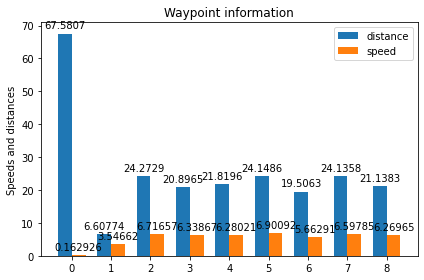

In [17]:
dist_list = []
speed_list = []

for x1, y1, h1, x2, y2, h2, (g_speed, v_speed) in zip(waypoints_x, waypoints_y, waypoints_height, cmd_x, cmd_y, cmd_alt, cmd_speed):
    dist_list.append(math.dist([x1, y1, h1], [x2, y2, h2]))
    speed_list.append(math.sqrt(math.pow(g_speed, 2) + math.pow(v_speed, 2)))

print(speed_list)

labels = range(len(dist_list))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dist_list, width, label='distance')
rects2 = ax.bar(x + width/2, speed_list, width, label='speed')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speeds and distances')
ax.set_title('Title 1')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.title("Waypoint information")
plt.show()

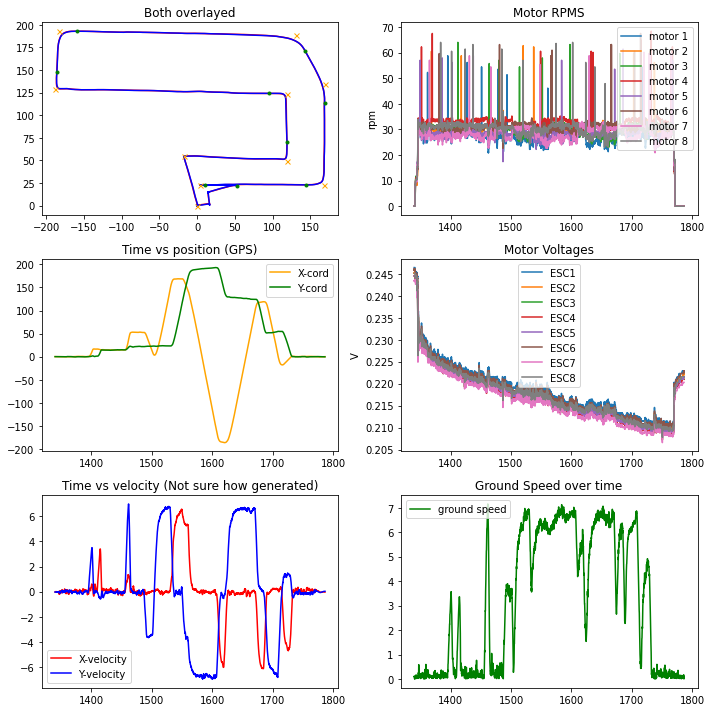

In [18]:
figure(figsize=(10, 10))

plt.subplot(3, 2, 1)

plt.plot(pos_x_cords, pos_y_cords, c='r')
plt.plot(gps_x_cords, gps_y_cords, c='b')

for x, y in zip(cmd_x, cmd_y):
    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="green", markerfacecolor="green")

for x, y in zip(waypoints_x, waypoints_y):
    plt.plot(x, y, marker="x", markersize=5, markeredgecolor="orange", markerfacecolor="orange")

plt.title("Both overlayed")

# plt.plot(gps_x_cords, gps_y_cords, c='b', label = 'path')
# plt.title("GPS Cords")

plt.subplot(3, 2, 2)

for i in range(1,9):
    fmt_type = "ESC" + str(i)
    ecs_time = DATA[fmt_type]['timeus'] * COLs[fmt_type]['mult_factor']['timeus']
    ecs_volts = DATA[fmt_type]['rpm'] * COLs[fmt_type]['mult_factor']['rpm']
    plt.plot(ecs_time, ecs_volts, label = 'motor %d' % i)

plt.ylabel(COLs['ESC1']['units']['rpm'])
plt.legend()
plt.title("Motor RPMS")

# plt.plot(pos_x_cords, pos_y_cords, c='r', label = 'path')
# plt.title("Position Cords (Probably By IMU)")

plt.subplot(3, 2, 3)

plt.plot(gps_time, gps_x_cords, c='orange', label = 'X-cord')
plt.plot(gps_time, gps_y_cords, c='g', label = 'Y-cord')
plt.legend()
plt.title("Time vs position (GPS)")

plt.subplot(3, 2, 4)

for i in range(1,9):
    fmt_type = "ESC" + str(i)
    ecs_time = DATA[fmt_type]['timeus'] * COLs[fmt_type]['mult_factor']['timeus']
    ecs_volts = DATA[fmt_type]['volt'] * COLs[fmt_type]['mult_factor']['volt']
    plt.plot(ecs_time, ecs_volts, label = fmt_type)

plt.legend()
plt.ylabel(COLs['ESC1']['units']['volt'])
plt.title("Motor Voltages")

plt.subplot(3, 2, 5)

plt.plot(psc_time, psc_velocities['vx'], c= 'r', label= "X-velocity")
plt.plot(psc_time, psc_velocities['vy'], c='b', label= "Y-velocity")
plt.legend()
plt.title("Time vs velocity (Not sure how generated)")

plt.subplot(3, 2, 6)

plt.plot(gps_time, gps_gr_spd, c='g', label='ground speed')
plt.legend()
plt.title("Ground Speed over time")

plt.tight_layout()

-0.01083087659208104, -0.13300312962383032
3.646959532168694, 22.706224111374468
167.6616320971516, 22.687046388629824
169.2887650509365, 134.24132923595607
130.9807045031921, 188.4419847074896
-183.63474754593335, 193.03840187052265
-188.38434549281374, 129.01282469742
119.54616219369927, 123.57064517308027
118.46555489534512, 49.51545929303393
-17.81297195784282, 55.31130521791056

0.0, 0.0, 30.0
164.0146725649829, -0.019177722744643688, 30.0
165.6418055187678, 111.5351051245816, 30.0
127.3337449710234, 165.73576059611514, 30.0
-187.28170707810204, 170.33217775914818, 45.0
-192.03130502498243, 106.30660058604553, 45.0
115.89920266153058, 100.8644210617058, 30.0
114.81859536317643, 26.80923518165946, 30.0
-21.459931490011513, 32.60508110653609, 30.0


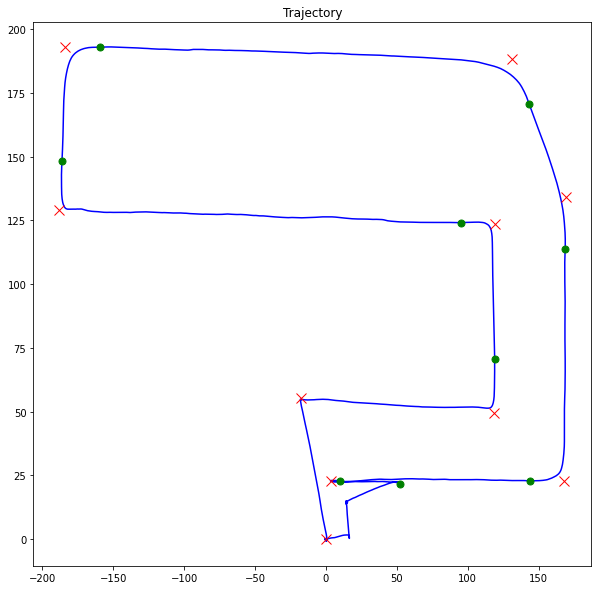

In [19]:
figure(figsize=(10, 10))

plt.plot(gps_x_cords, gps_y_cords, c='b')

for x, y in zip(cmd_x, cmd_y):
    plt.plot(x, y, marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green", label='way point received')

for x, y in zip(waypoints_x, waypoints_y):
    plt.plot(x, y, marker="x", markersize=10, markeredgecolor="red", markerfacecolor="red", label='waypoint')

plt.title("Trajectory")

for x, y in zip(waypoints_x, waypoints_y):
    print(str(x) + ", " + str(y))

wp_remove = 1

new_waypoints_x = np.asarray(waypoints_x[wp_remove:])
new_waypoints_y = np.asarray(waypoints_y[wp_remove:])
new_wp_height = np.asarray(waypoints_height[wp_remove:])

new_waypoints_x = new_waypoints_x - waypoints_x[wp_remove]
new_waypoints_y = new_waypoints_y - waypoints_y[wp_remove]

print()

for x, y, z in zip(new_waypoints_x, new_waypoints_y, new_wp_height):
    print(str(x) + ", " + str(y) + ", " + str(z))

In [20]:
att_frame = DATA['ATT']
att_time = att_frame['timeus'] / 1000000
att_des_roll = att_frame['desroll']

cmd_att_time = []
cmd_roll = []
cmd_gps_time = []
cmd_grd_spd = []


for time in in_line_cmds:
    val = binary_search(time * (1/1000000), att_time)
    cmd_att_time.append(att_time[val])
    cmd_roll.append(att_des_roll[val])

    val2 = binary_search(time * (1/1000000), gps_time)
    cmd_gps_time.append(gps_time[val2])
    cmd_grd_spd.append(gps_gr_spd[val2])

rate_frame = DATA['RATE']
rate_time = rate_frame['timeus'] / 1000000

waypoint_num = 3
waypoint_window = 40 # in seconds
waypoint_num = waypoint_num - 1

waypoint_gps_time = cmd_gps_time[waypoint_num]
waypoint_start = waypoint_gps_time - waypoint_window/4
waypoint_end = waypoint_gps_time + waypoint_window

att_start_index = binary_search(waypoint_start, att_time)
att_end_index = binary_search(waypoint_end, att_time)

rate_start_index = binary_search(waypoint_start, rate_time)
rate_end_index = binary_search(waypoint_end, rate_time)

Text(0.5, 1.0, 'Rate around a turning waypoint')

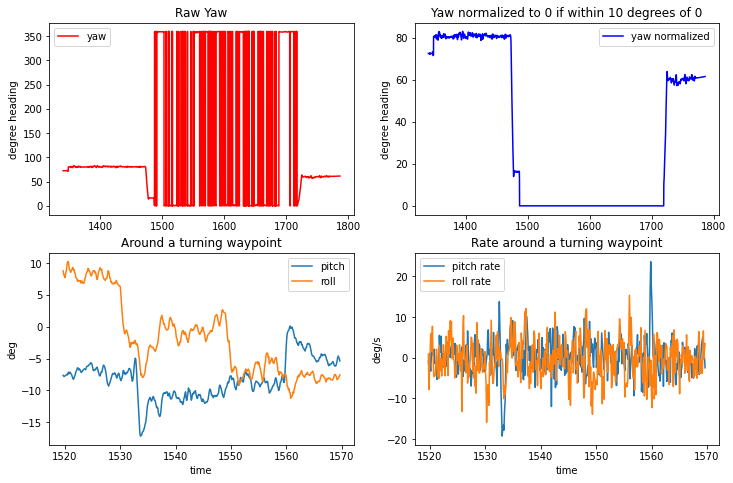

In [21]:
att_yaw = att_frame['yaw']

figure(figsize=(12, 12), layout=None)

plt.subplot(3, 2, 1)
plt.plot(att_time, att_yaw, label='yaw', c='r')
plt.legend()
plt.title("Raw Yaw")
plt.ylabel("degree heading")

plt.subplot(3, 2, 2)
plt.plot(att_time, [0 if abs(yaw-0) < 10 or abs(yaw-360) < 10 else yaw for yaw in att_yaw], label ='yaw normalized', c='b')
plt.legend()
plt.ylabel("degree heading")
plt.title("Yaw normalized to 0 if within 10 degrees of 0")

plt.subplot(3, 2, 3)
plt.plot(att_time[att_start_index:att_end_index], att_frame['pitch'][att_start_index:att_end_index], label = 'pitch')
plt.plot(att_time[att_start_index:att_end_index], att_frame['roll'][att_start_index:att_end_index], label = 'roll')
plt.ylabel('deg')
plt.xlabel('time')
plt.legend()

plt.title("Around a turning waypoint")

plt.subplot(3, 2, 4)
plt.plot(rate_time[rate_start_index:rate_end_index], rate_frame['p'][rate_start_index:rate_end_index], label='pitch rate')
plt.plot(rate_time[rate_start_index:rate_end_index], rate_frame['r'][rate_start_index:rate_end_index], label='roll rate')
plt.ylabel('deg/s')
plt.xlabel('time')
plt.legend()

plt.title('Rate around a turning waypoint')

#plt.savefig("yaw.png")

Text(0, 0.5, 'deg/s')

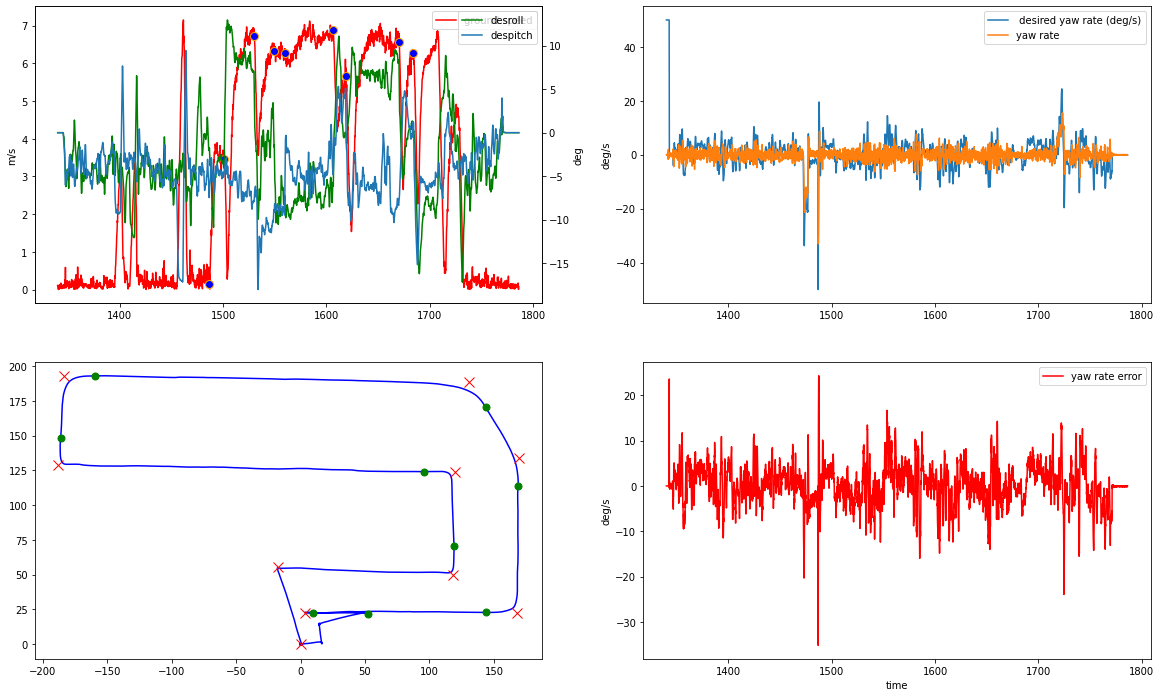

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20,12))
ax_0 = ax[0][0]
ax_0.plot(gps_time, gps_gr_spd, c='r', label='ground speed')
plt.xlabel("time")
ax_0.set_ylabel("m/s")
ax_0.legend()

for time, pos in zip(cmd_gps_time, cmd_grd_spd):
    ax_0.plot(time, pos, marker="o", markersize=8, markeredgecolor="orange", markerfacecolor="blue")

ax2 = ax_0.twinx()
ax2.plot(att_time, att_frame['desroll'], c = 'g', label='desroll')
ax2.plot(att_time, att_frame['despitch'], label='despitch')
#ax2.plot(att_time, att_frame['desyaw'], label='desyaw')
ax2.set_ylabel('deg')
ax2.legend()

ax_1 = ax[1][0]
ax_1.plot(gps_x_cords, gps_y_cords, c='b')

for x, y in zip(cmd_x, cmd_y):
    ax_1.plot(x, y, marker="o", markersize=7, markeredgecolor="green", markerfacecolor="green", label='way point received')

for x, y in zip(waypoints_x, waypoints_y):
    ax_1.plot(x, y, marker="x", markersize=10, markeredgecolor="red", markerfacecolor="red", label='waypoint')

ax_2 = ax[0][1]

ax_2.plot(rate_time, [50 * (yaw_rate/abs(yaw_rate)) if abs(yaw_rate) > 50 else yaw_rate for yaw_rate in rate_frame['ydes']], label=' desired yaw rate (deg/s)')
ax_2.plot(rate_time, rate_frame['y'], label='yaw rate')

ax_2.legend()
ax_2.set_ylabel('deg/s')

ax_3 = ax[1][1]

ax_3.plot(rate_time, [0 if abs(des_y_r - yaw_r) > 50 else des_y_r-yaw_r for des_y_r, yaw_r in zip(rate_frame['ydes'], rate_frame['y'])], label='yaw rate error', c='r')
ax_3.legend()
ax_3.set_ylabel('deg/s')

#plt.savefig('pitch and roll.png')

Text(0.5, 1.0, 'Motor Voltages')

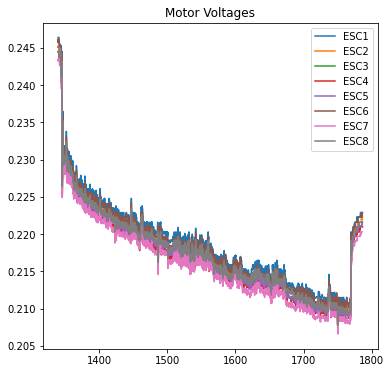

In [23]:
figure(figsize=(6, 6))

for i in range(1,9):
    fmt_type = "ESC" + str(i)
    ecs_time = DATA[fmt_type]['timeus'] * COLs[fmt_type]['mult_factor']['timeus']
    ecs_volts = DATA[fmt_type]['volt'] * COLs[fmt_type]['mult_factor']['volt']
    plt.plot(ecs_time, ecs_volts, label = fmt_type)

plt.legend()
plt.title("Motor Voltages")

In [24]:
COLs['ESC1']

{'col_names': ['timeus', 'rpm', 'volt', 'curr', 'temp', 'ctot'],
 'units': {'timeus': 's',
  'rpm': 'rpm',
  'volt': 'V',
  'curr': 'A',
  'temp': 'degC',
  'ctot': ''},
 'mult_factor': {'timeus': 9.99999997475243e-07,
  'rpm': 0.00999999977648258,
  'volt': 0.00999999977648258,
  'curr': 0.00999999977648258,
  'temp': 0.00999999977648258,
  'ctot': 0.0},
 'data_type': ['Q', 'e', 'C', 'C', 'c', 'H']}

Text(0.5, 1.0, 'Motor RPMS')

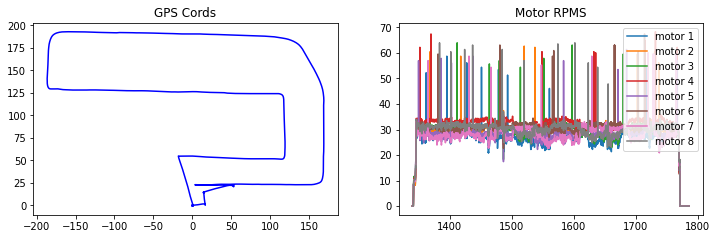

In [25]:
figure(figsize=(12, 12))

plt.subplot(3, 2, 1)

plt.plot(gps_x_cords, gps_y_cords, c='b', label = 'path')
plt.title("GPS Cords")

plt.subplot(3, 2, 2)

for i in range(1,9):
    fmt_type = "ESC" + str(i)
    ecs_time = DATA[fmt_type]['timeus'] * COLs[fmt_type]['mult_factor']['timeus']
    ecs_volts = DATA[fmt_type]['rpm'] * COLs[fmt_type]['mult_factor']['rpm']
    plt.plot(ecs_time, ecs_volts, label = 'motor %d' % i)

plt.legend()
plt.title("Motor RPMS")

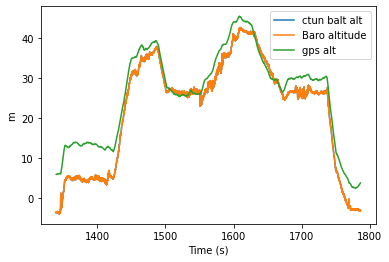

In [26]:
control_tuning_frame = DATA['CTUN']
baro_frame = DATA['BARO']
ctun_time = control_tuning_frame['timeus'] / 1000000
baro_time = baro_frame['timeus'] / 1000000

#plt.plot(ctun_time, control_tuning_frame['alt'], label='ctun alt')
#plt.plot(ctun_time, control_tuning_frame['dalt'], label='ctun desired alt')
plt.plot(ctun_time, control_tuning_frame['balt'], label='ctun balt alt')
plt.plot(baro_time, baro_frame['alt'], label="Baro altitude")
plt.plot(gps_time, gps_alt, label='gps alt')
plt.xlabel("Time (s)")
plt.ylabel(COLs['CTUN']['units']['alt'])
plt.legend()
plt.show()

In [27]:
counts['ATT']

4290

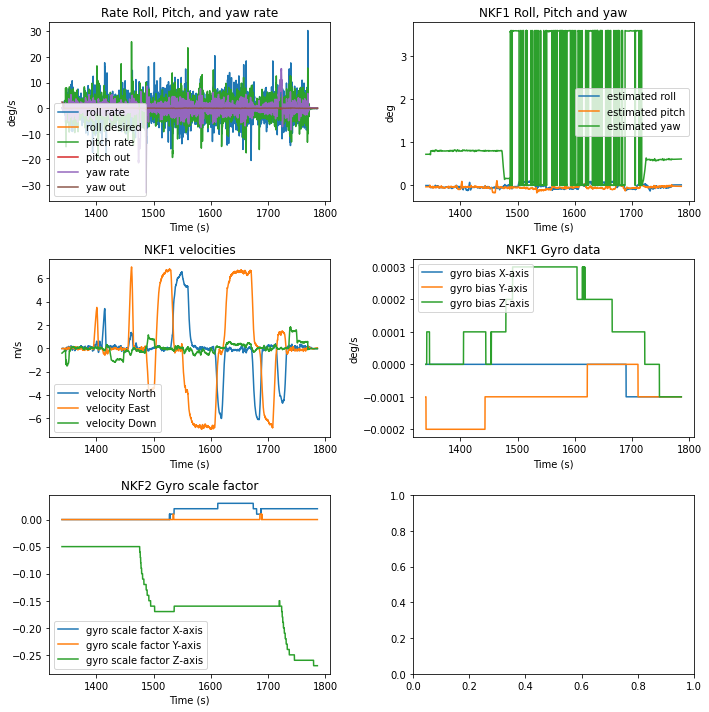

In [28]:
att_frame = DATA['ATT']
rate_frame = DATA['RATE']
nfk1_frame = DATA['NKF1']
nfk2_frame = DATA['NKF2']
ahr2_frame = DATA['AHR2']
att_time = att_frame['timeus'] / 1000000
rate_time = rate_frame['timeus'] / 1000000
nfk1_time = nfk1_frame['timeus'] / 1000000
nfk2_time = nfk2_frame['timeus'] / 1000000
ahr2_time = ahr2_frame['timeus'] / 1000000

figure(figsize=(10, 10))

plt.subplot(3, 2, 1)

plt.plot(rate_time, rate_frame['r'] * COLs['RATE']['mult_factor']['r'], label= 'roll rate')
plt.plot(rate_time, rate_frame['rout'] * COLs['RATE']['mult_factor']['rout'], label= 'roll desired')
plt.plot(rate_time, rate_frame['p'] * COLs['RATE']['mult_factor']['p'], label= 'pitch rate')
plt.plot(rate_time, rate_frame['pout'] * COLs['RATE']['mult_factor']['pout'], label= 'pitch out')
plt.plot(rate_time, rate_frame['y'] * COLs['RATE']['mult_factor']['y'], label= 'yaw rate')
plt.plot(rate_time, rate_frame['yout'] * COLs['RATE']['mult_factor']['yout'], label= 'yaw out')
plt.ylabel(COLs['RATE']['units']['r'])
plt.xlabel("Time (s)")
plt.legend()
plt.title("Rate Roll, Pitch, and yaw rate")

plt.subplot(3, 2, 2)

plt.plot(nfk1_time, nfk1_frame['roll'] * COLs['NKF1']['mult_factor']['roll'], label='estimated roll')
plt.plot(nfk1_time, nfk1_frame['pitch'] * COLs['NKF1']['mult_factor']['pitch'], label='estimated pitch')
plt.plot(nfk1_time, nfk1_frame['yaw'] * COLs['NKF1']['mult_factor']['yaw'], label='estimated yaw')
plt.ylabel(COLs['NKF1']['units']['roll'])
plt.xlabel("Time (s)")
plt.legend()
plt.title("NKF1 Roll, Pitch and yaw")

plt.subplot(3, 2, 3)

plt.plot(nfk1_time, nfk1_frame['vn'] * COLs['NKF1']['mult_factor']['vn'], label='velocity North')
plt.plot(nfk1_time, nfk1_frame['ve'] * COLs['NKF1']['mult_factor']['ve'], label='velocity East')
plt.plot(nfk1_time, nfk1_frame['vd'] * COLs['NKF1']['mult_factor']['vd'], label='velocity Down')
plt.ylabel(COLs['NKF1']['units']['vn'])
plt.xlabel('Time (s)')
plt.legend()
plt.title("NKF1 velocities")

plt.subplot(3, 2, 4)

plt.plot(nfk1_time, nfk1_frame['gx'] * COLs['NKF1']['mult_factor']['gx'], label='gyro bias X-axis')
plt.plot(nfk1_time, nfk1_frame['gy'] * COLs['NKF1']['mult_factor']['gy'], label='gyro bias Y-axis')
plt.plot(nfk1_time, nfk1_frame['gz'] * COLs['NKF1']['mult_factor']['gz'], label='gyro bias Z-axis')
plt.ylabel(COLs['NKF1']['units']['gx'])
plt.xlabel("Time (s)")
plt.legend()
plt.title("NKF1 Gyro data")

plt.subplot(3, 2, 5)

plt.plot(nfk2_time, nfk2_frame['gsx'], label='gyro scale factor X-axis')
plt.plot(nfk2_time, nfk2_frame['gsy'], label='gyro scale factor Y-axis')
plt.plot(nfk2_time, nfk2_frame['gsz'], label='gyro scale factor Z-axis')
plt.ylabel(COLs['NKF2']['units']['gsx'])
plt.xlabel("Time (s)")
plt.legend()
plt.title("NKF2 Gyro scale factor")

plt.subplot(3, 2, 6)

plt.tight_layout()


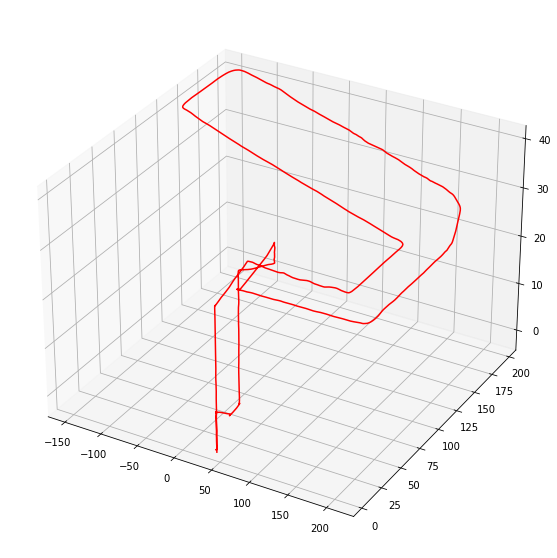

In [29]:
fig =plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.plot3D(nfk1_frame['pe'], nfk1_frame['pn'], nfk1_frame['pd'] * -1, 'red')

In [30]:
bat_frame = DATA['BAT']
bat_time = bat_frame['timeus'] / 1000000
bat_volt = bat_frame['volt']
bat_curr = bat_frame['curr']

imu_frame = DATA['IMU']
imu_time = imu_frame['timeus'] / 1000000

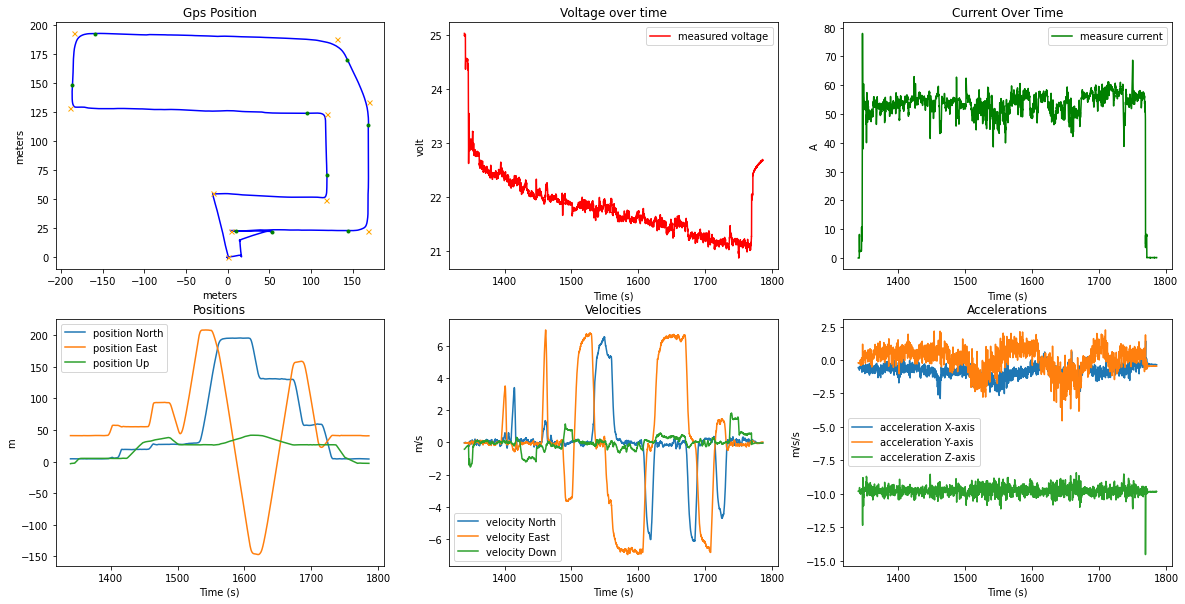

In [31]:
figure(figsize=(20, 10))

plt.subplot(2, 3, 1)

plt.plot(gps_x_cords, gps_y_cords, c='b')

for x, y in zip(cmd_x, cmd_y):
    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="green", markerfacecolor="green")

for x, y in zip(waypoints_x, waypoints_y):
    plt.plot(x, y, marker="x", markersize=5, markeredgecolor="orange", markerfacecolor="orange")

plt.xlabel("meters")
plt.ylabel("meters")
plt.title("Gps Position")

plt.subplot(2, 3, 2)

plt.plot(bat_time, bat_volt, c='r', label='measured voltage')
plt.ylabel('volt')
plt.xlabel('Time (s)')
plt.legend()
plt.title("Voltage over time")

plt.subplot(2, 3, 3)

plt.plot(bat_time, bat_curr, c='g',label='measure current')
plt.ylabel('A')
plt.xlabel('Time (s)')
plt.legend()
plt.title("Current Over Time")

plt.subplot(2, 3, 4)

plt.plot(nfk1_time, nfk1_frame['pn'] * COLs['NKF1']['mult_factor']['pn'], label='position North')
plt.plot(nfk1_time, nfk1_frame['pe'] * COLs['NKF1']['mult_factor']['pe'], label='position East')
plt.plot(nfk1_time, -1 * nfk1_frame['pd'] * COLs['NKF1']['mult_factor']['pd'], label='position Up')
plt.ylabel(COLs['NKF1']['units']['pn'])
plt.xlabel('Time (s)')
plt.legend()
plt.title("Positions")

plt.subplot(2, 3, 5)

plt.plot(nfk1_time, nfk1_frame['vn'] * COLs['NKF1']['mult_factor']['vn'], label='velocity North')
plt.plot(nfk1_time, nfk1_frame['ve'] * COLs['NKF1']['mult_factor']['ve'], label='velocity East')
plt.plot(nfk1_time, nfk1_frame['vd'] * COLs['NKF1']['mult_factor']['vd'], label='velocity Down')
plt.ylabel(COLs['NKF1']['units']['vn'])
plt.xlabel('Time (s)')
plt.legend()
plt.title("Velocities")

plt.subplot(2, 3, 6)

skip = 6

plt.plot(imu_time[::skip], imu_frame['accx'][::skip] * COLs['IMU']['mult_factor']['accx'], label='acceleration X-axis')
plt.plot(imu_time[::skip], imu_frame['accy'][::skip] * COLs['IMU']['mult_factor']['accy'], label='acceleration Y-axis')
plt.plot(imu_time[::skip], imu_frame['accz'][::skip] * COLs['IMU']['mult_factor']['accz'], label='acceleration Z-axis')
plt.ylabel(COLs['IMU']['units']['accx'])
plt.xlabel('Time (s)')
plt.legend()
plt.title("Accelerations")

plt.savefig('2022-05-05_profiles.png')

In [32]:
imu_frame_test = imu_frame[['timeus', 'accx', 'accy', 'accz']]

bat_frame_test = bat_frame[['timeus', 'volt', 'curr']]

nfk1_frame_test = nfk1_frame[['timeus', 'pn', 'pe', 'pd', 'vn', 've', 'vd']]
nfk1_frame_test = nfk1_frame_test.rename(columns={"pn": "position_north", "pe": "position_east", 'pd': "position_down",
                                "vn": "velocity_north", "ve": "velocity_east", "vd": "velocity_down"}, errors="raise")

imu_frame_test.to_csv('DataForTim/acceleration.csv')
bat_frame_test.to_csv('DataForTim/battery.csv')
nfk1_frame_test.to_csv('DataForTim/position_and_velocity.csv')

In [33]:
time_dif = [bat_time[i+1] - bat_time[i] for i in range(len(bat_time)-1)]
print(np.average(time_dif))

0.1040634733038004


In [34]:
time_dif_2 = [imu_time[i+1] - imu_time[i] for i in range(len(imu_time)-1)]
print(np.average(time_dif_2))


0.0416444525186567


In [35]:
terr_frame = DATA['TERR']
terr_time = terr_frame['timeus'] / 1000000
terr_frame

,timeus,status,lat,lng,spacing,terrh,cheight,pending,loaded
0,1.340351e+09,2.0,37.102305,-76.386968,100.0,2.457732,0.247517,0.0,504.0
1,1.341351e+09,2.0,37.102306,-76.386968,100.0,2.455519,0.451888,0.0,504.0
2,1.342354e+09,2.0,37.102306,-76.386968,100.0,2.456407,0.585322,0.0,504.0
3,1.343359e+09,2.0,37.102305,-76.386968,100.0,2.458565,0.669386,0.0,504.0
4,1.344364e+09,2.0,37.102305,-76.386968,100.0,2.459479,0.761912,0.0,504.0
...,...,...,...,...,...,...,...,...,...
425,1.781490e+09,2.0,37.102304,-76.386973,100.0,2.467101,0.622490,0.0,504.0
426,1.782495e+09,2.0,37.102303,-76.386973,100.0,2.467503,0.611235,0.0,504.0
427,1.783499e+09,2.0,37.102303,-76.386972,100.0,2.467871,0.657275,0.0,504.0
428,1.784504e+09,2.0,37.102303,-76.386972,100.0,2.468200,0.683504,0.0,504.0


In [36]:
DATA["CTRL"]

,timeus,rmsrollp,rmsrolld,rmspitchp,rmspitchd,rmsyaw
0,1.339856e+09,0.028181,0.000769,0.052702,0.002307,2.292164
1,1.339957e+09,0.027939,0.000690,0.053415,0.001900,2.336133
2,1.340058e+09,0.027820,0.000693,0.054027,0.001583,2.365033
3,1.340159e+09,0.027715,0.000626,0.054457,0.001327,2.384156
4,1.340259e+09,0.027640,0.000562,0.054680,0.001104,2.397022
...,...,...,...,...,...,...
4285,1.785807e+09,0.010861,0.000380,0.025677,0.000387,0.001035
4286,1.785908e+09,0.010847,0.000420,0.025695,0.000364,0.001075
4287,1.786008e+09,0.010867,0.000372,0.025706,0.000334,0.001071
4288,1.786109e+09,0.010843,0.000391,0.025667,0.000350,0.001065


In [37]:
position_fmts = ['BARO', 'GPS', 'IMU', 'IMU2', 'IMU3', 'ATT',
                 'NKF1', 'NKF2', 'NKF3', 'NKF4', 'NKF5', 'NKF6', 'NKF7',
                 'NKF8', 'NKF9', 'NKQ1', 'NKQ2', 'AHR2', 'POS', 'PSC', 'VIBE',
                 'MAG', 'MAG2', 'MAG3', 'RATE', 'CTRL']

motor_fmts = ['MOTB','ESC1','ESC2', 'ESC3', 'ESC4', 'ESC5', 'ESC6', 'ESC7', 'ESC8',
              'CTUN']

battery_fmts = ['BAT', 'POWR']

all_fmts = position_fmts + motor_fmts + battery_fmts


In [38]:
large_nums = [fmt for fmt in counts.keys() if counts[fmt] > 2000]

for fmt in all_fmts:
    if fmt not in large_nums:
        print(fmt, "Is not large enough")

to_return = ""
for elem in large_nums:
    time_frame_itr = DATA[elem]['timeus'] * COLs[elem]['mult_factor']['timeus']
    time_dif_itr = [time_frame_itr[i+1] - time_frame_itr[i] for i in range(len(time_frame_itr)-1)]
    print(elem + ": " + str(counts[elem]) + " " + str(round(np.average(time_dif_itr), 3)))
    to_return = to_return + elem + "\t" + str(counts[elem]) + '\t' + str(round(np.average(time_dif_itr), 3)) + "\n"

#pyperclip.copy(to_return)


BARO: 4291 0.104
BAR2: 4291 0.104
CTUN: 4291 0.104
GPS: 2233 0.2
GPA: 2233 0.2
IMU: 10721 0.042
IMU2: 10721 0.042
IMU3: 10720 0.042
BAT: 4290 0.104
POWR: 4290 0.104
MAG: 4290 0.104
MAG2: 4290 0.104
MAG3: 4290 0.104
ATT: 4290 0.104
RATE: 4290 0.104
NKF1: 4290 0.104
NKF2: 4290 0.104
NKF3: 4290 0.104
NKF4: 4290 0.104
NKF5: 4290 0.104
NKQ1: 4290 0.104
NKF6: 4290 0.104
NKF7: 4290 0.104
NKF8: 4290 0.104
NKF9: 4290 0.104
NKQ2: 4290 0.104
AHR2: 4290 0.104
POS: 4290 0.104
MOTB: 4290 0.104
RCIN: 4292 0.104
RSSI: 4290 0.104
RCOU: 4290 0.104
PSC: 4290 0.104
VIBE: 4290 0.104
CTRL: 4290 0.104
ESC1: 4270 0.105
ESC2: 4268 0.105
ESC3: 4269 0.105
ESC4: 4272 0.104
ESC5: 4268 0.105
ESC6: 4271 0.105
ESC7: 4277 0.104
ESC8: 4267 0.105


In [40]:
COLs

{'FMT': {'col_names': ['type', 'length', 'name', 'format', 'columns'],
  'units': {'type': '',
   'length': 'B',
   'name': '',
   'format': '',
   'columns': ''},
  'mult_factor': {'type': 0.0,
   'length': 0.0,
   'name': 0.0,
   'format': 0.0,
   'columns': 0.0},
  'data_type': ['B', 'B', 'n', 'N', 'Z']},
 'UNIT': {'col_names': ['timeus', 'id', 'label'],
  'units': {'timeus': 's', 'id': '', 'label': ''},
  'mult_factor': {'timeus': 9.99999997475243e-07, 'id': 0.0, 'label': 0.0},
  'data_type': ['Q', 'b', 'Z']},
 'FMTU': {'col_names': ['timeus', 'fmttype', 'unitids', 'multids'],
  'units': {'timeus': 's', 'fmttype': '', 'unitids': '', 'multids': ''},
  'mult_factor': {'timeus': 9.99999997475243e-07,
   'fmttype': 0.0,
   'unitids': 0.0,
   'multids': 0.0},
  'data_type': ['Q', 'B', 'N', 'N']},
 'MULT': {'col_names': ['timeus', 'id', 'mult'],
  'units': {'timeus': 's', 'id': '', 'mult': ''},
  'mult_factor': {'timeus': 9.99999997475243e-07, 'id': 0.0, 'mult': 0.0},
  'data_type': ['Q'

In [39]:
def get_col_names_from_fmts(fmt_list):
    to_return = ['timeus']
    for fmt_key in fmt_list:
        for name in COLs[fmt_key]['col_names']:
            if name != 'timeus':
                if fmt_key[-1].isnumeric():
                    name = name + fmt_key[-1]
                to_return.append(name)
    return to_return

def get_units_from_col_names(col_names_1):
    to_return = {}
    for fmt_key in col.keys():
        for name in COLs[fmt_key]['col_names']:
            if name in col_names_1:
                to_return[fmt_key] = COLs[fmt_key]['units'][name]

    return to_return

def write_col_descriptions(fmt_list, folder_name=cur_folder):
    with open(folder_name + "/column_descriptions.txt", 'w', encoding='utf8') as data_desc:
        data_desc.write("timeus: microseconds since system startup (us)\n\n")
        for fmt_key in fmt_list:
            data_desc.write(fmt_key + ": ")
            data_desc.write(format_descriptions[fmt_key]['general'] + '\n')
            for name in COLs[fmt_key]['col_names']:
                n = ""
                if fmt_key[-1].isnumeric():
                    n = fmt_key[-1]

                if name == 'timeus':
                    continue
                if name not in format_descriptions[fmt_key].keys():
                    data_desc.write(name + n + ": UNKNOWN")
                else:
                    data_desc.write(name + n + ": " + format_descriptions[fmt_key][name])

                if COLs[fmt_key]['units'][name] != '':
                    data_desc.write(' (' + COLs[fmt_key]['units'][name] + ')')

                data_desc.write('\n')
            data_desc.write('\n')



In [42]:
# creating the data frame
grouping_fmt = 'BAT'
fmts_to_get = all_fmts
bat_frame = DATA['BAT']
time = np.asarray(bat_frame['timeus'])

time_data = {}
col_names = get_col_names_from_fmts(fmts_to_get)
for col in col_names:
    time_data[col] = []

time_data = pd.DataFrame(time_data)

row_count = 0

with open(path_to_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    start_time = None
    cur_row = {}
    for row in csv_reader:
        row_count = row_count + 1
        if row_count % 5000 == 0:
            print(row_count)
        cur_fmt = row[0]
        if cur_fmt not in fmts_to_get and cur_fmt != grouping_fmt:
            continue

        if start_time is None and cur_fmt == grouping_fmt:
            start_log = True
        elif start_time is None:
            continue

        if cur_fmt in fmts_to_get:
            for i, (col_name, data_type) in enumerate(zip(COLs[cur_fmt]['col_names'], COLs[cur_fmt]['data_type'])):
                added_num = False

                if col_name == 'timeus':
                    continue
                if cur_fmt[-1].isnumeric():
                    col_name = col_name + cur_fmt[-1]
                    added_num = True

                if isinstance(row[i], list): # Some rows come in as 2d lists for some reason
                    cur_row[col_name] = [convert_data_point(row[i+1][0], data_type)]
                else:
                    cur_row[col_name] = [convert_data_point(row[i+1], data_type)]

                mult_fact = COLs[cur_fmt]['mult_factor'][col_name[:-1] if added_num else col_name]
                if mult_fact != 0.0 and (isinstance(cur_row[col_name], int) or isinstance(cur_row[col_name], float)):
                    cur_row[col_name] = cur_row[col_name] * mult_fact


        if cur_fmt == grouping_fmt:
            total_time = 0
            if start_time is None:
                if isinstance(row[1], list):
                    start_time = int(row[1][0])
                else:
                    start_time = int(row[1])
            else:
                if isinstance(row[1], list):
                    total_time = int((int(row[1][0]) + start_time)/2)
                    start_time = int(row[1][0])
                else:
                    total_time = int((int(row[1]) + start_time)/2)
                    start_time = int(row[1])

                cur_row['timeus'] = total_time
                cur_row = pd.DataFrame(cur_row)
                time_data = pd.concat([time_data, cur_row], ignore_index = True)
                cur_row = {}

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000


In [43]:
output_file_path = cur_folder + '/' + 'time_data.csv'

time_data.to_csv(output_file_path)

In [40]:
write_col_descriptions(all_fmts)

In [44]:
format_descriptions

{'FMT': {'general': 'Message defining the format of messages in this file',
  'type': 'unique-to-this-log identifier for message being defined',
  'length': 'the number of bytes taken up by this message (including all headers)',
  'name': 'name of the message being defined',
  'format': 'character string defining the C-storage-type of the fields in this message',
  'columns': 'the labels of the message being defined'},
 'UNIT': {'general': 'Message mapping from single character to SI unit',
  'timeus': 'Time since system startup',
  'id': 'character referenced by FMTU',
  'label': 'Unit - SI where available'},
 'MULT': {'general': 'Message mapping from single character to numeric multiplier',
  'timeus': 'Time since system startup',
  'id': 'character referenced by FMTU',
  'mult': 'numeric multiplier'},
 'EV': {'general': 'Specifically coded event messages',
  'timeus': 'Time since system startup',
  'id': 'Event identifier\nValues:\n\n\n\n\n\n\n\nARMED\n10\n\n\nDISARMED\n11\n\n\nAUTO

In [45]:
DATA['MOTB'].to_csv('data/bat_per_data.csv')

In [45]:
COLs["ESC1"]

{'col_names': ['timeus', 'rpm', 'volt', 'curr', 'temp', 'ctot'],
 'units': {'timeus': 's',
  'rpm': 'rpm',
  'volt': 'V',
  'curr': 'A',
  'temp': 'degC',
  'ctot': ''},
 'mult_factor': {'timeus': 9.99999997475243e-07,
  'rpm': 0.00999999977648258,
  'volt': 0.00999999977648258,
  'curr': 0.00999999977648258,
  'temp': 0.00999999977648258,
  'ctot': 0.0},
 'data_type': ['Q', 'e', 'C', 'C', 'c', 'H']}

In [47]:
def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

# Reading the PID Params:
PID_PARAMs = {}
found_params = []
missing_params = []
cur_param = None
cur_desc = ''

with open('PID_params.txt', 'r') as PID_file:
    file = PID_file.readlines()

    for row in file:
        if row == '' or row == '\n':
            if cur_param in found_params:
                cur_desc = rreplace(cur_desc, "\n", "", 1)
                cur_desc = cur_desc.replace('\n', ". ")
                PID_PARAMs[cur_param]['desc'] = cur_desc
            cur_param = None
            cur_desc = ''
            continue

        param = row.split(" ")[0]
        if param[-1] == ':':
            param = param[:-1]

        if param.upper() != param:
            if cur_param is not None:
                cur_desc = cur_desc + row
            continue
        else:
            cur_param = param

        if param in PARAMs.keys():
            found_params.append(param)
            PID_PARAMs[cur_param] = {}
            PID_PARAMs[cur_param]['value'] = PARAMs[cur_param]['value']
            PID_PARAMs[cur_param]['short_desc'] = row[len(row.split(" ")[0]) + 1:].replace('\n', '')
        else:
            missing_params.append(param)

    if cur_param is not None and cur_param in found_params:
        cur_desc = rreplace(cur_desc, "\n", "", 1)
        cur_desc = cur_desc.replace('\n', ". ")
        PID_PARAMs[cur_param]['desc'] = cur_desc


In [48]:
found_params

['AHRS_GPS_GAIN',
 'ATC_ANG_RLL_P',
 'ATC_ANG_PIT_P',
 'ATC_ANG_YAW_P',
 'ATC_RAT_RLL_P',
 'ATC_RAT_RLL_I',
 'ATC_RAT_RLL_IMAX',
 'ATC_RAT_RLL_D',
 'ATC_RAT_PIT_P',
 'ATC_RAT_PIT_I',
 'ATC_RAT_PIT_IMAX',
 'ATC_RAT_PIT_D',
 'ATC_RAT_YAW_P',
 'ATC_RAT_YAW_I',
 'ATC_RAT_YAW_IMAX',
 'ATC_RAT_YAW_D',
 'ATC_RAT_RLL_P',
 'ATC_RAT_RLL_I',
 'ATC_RAT_RLL_I',
 'ATC_RAT_RLL_I',
 'ATC_RAT_PIT_P',
 'ATC_RAT_PIT_P',
 'ATC_RAT_PIT_IMAX',
 'ATC_RAT_PIT_D',
 'ATC_RAT_YAW_P',
 'ATC_RAT_YAW_I',
 'ATC_RAT_YAW_IMAX',
 'ATC_RAT_YAW_D',
 'PSC_POSZ_P',
 'PSC_VELZ_P',
 'PSC_ACCZ_P',
 'PSC_ACCZ_I',
 'PSC_ACCZ_IMAX',
 'PSC_ACCZ_D',
 'PSC_POSXY_P',
 'PSC_VELXY_P',
 'PSC_VELXY_I',
 'PSC_VELXY_D',
 'PSC_VELXY_IMAX',
 'AHRS_YAW_P',
 'AHRS_RP_P']

In [49]:
missing_params

['AROT_HS_P', 'AROT_FW_V_P', 'FOLL_POS_P']

In [50]:
PID_PARAMs

{'AHRS_GPS_GAIN': {'value': 1,
  'short_desc': 'AHRS GPS gain',
  'desc': 'Note: This parameter is for advanced users. This controls how much to use the GPS to correct the attitude. This should never be set to zero for a plane as it would result in the plane losing control in turns. For a plane please use the default value of 1.0.'},
 'ATC_ANG_RLL_P': {'value': 2.6875,
  'short_desc': 'Roll axis angle controller P gain',
  'desc': 'Roll axis angle controller P gain. Converts the error between the desired roll angle and actual angle to a desired roll rate'},
 'ATC_ANG_PIT_P': {'value': 4.5,
  'short_desc': 'Pitch axis angle controller P gain',
  'desc': 'Pitch axis angle controller P gain. Converts the error between the desired pitch angle and actual angle to a desired pitch rate'},
 'ATC_ANG_YAW_P': {'value': 4.5,
  'short_desc': 'Yaw axis angle controller P gain',
  'desc': 'Yaw axis angle controller P gain. Converts the error between the desired yaw angle and actual angle to a desire

In [51]:
with open(cur_folder + '/PID_list.txt', 'w', encoding='utf8') as output_file:

    for param in PID_PARAMs.keys():
        output_file.write(param + ": " + str(PID_PARAMs[param]['value']) + '\n')
        output_file.write(PID_PARAMs[param]['short_desc'] + '\n')
        output_file.write(PID_PARAMs[param]['desc'] + '\n\n')